In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install -q tensorflow keras segmentation-models albumentations
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
print("✅ All set up!")

# Extract dataset (replace with your path)
!unzip "/content/drive/MyDrive/Colab Notebooks/CVAI/Breast_Ultrasound.zip" -d "/content/data"

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.4 MB/s eta 0:00:00
✅ All set up!
Archive:  /content/drive/MyDrive/Colab Notebooks/CVAI/Breast_Ultrasound.zip
   creating: /content/data/Breast_Ultrasound/
   creating: /content/data/Breast_Ultrasound/benign/
  inflating: /content/data/Breast_Ultrasound/benign/benign (1).png  
  inflating: /content/data/Breast_Ultrasound/benign/benign (1)_mask.png  
  inflating: /content/data/Breast_Ultrasound/benign/benign (10).png  
  inflating: /content/data/Breast_Ultrasound/benign/benign (10)_mask.png  
  inflating: /content/data/Breast_Ultrasound/benign/benign (100).png  
  inflating: /content/data/Breast_Ultrasound/benign/benign (100)_mask.png  
  inflating: /content/data/Breast_Ultrasound/benign/benign (100)_mask_1.png  
  inflating: /content/data/Breast_Ultrasound/benign/benign (101).png  
  inflating: /content/data/Breast_Ultrasound/benign/benign (101)_mask.png  
  inflating: /content/data/Breast_Ultrasound/be

In [ ]:
# Define paths
data_dir = "/content/data/Breast_Ultrasound"
classes = ["benign", "malignant", "normal"]  # Subfolder names

# Load image and mask paths
image_paths = []
mask_paths = []

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for file in os.listdir(class_dir):
        if file.endswith(".png") and "_mask" not in file:  # Avoid loading masks
            img_path = os.path.join(class_dir, file)
            mask_path = os.path.join(class_dir, file.replace(".png", "_mask.png"))

            if os.path.exists(mask_path):  # Check if mask exists
                image_paths.append(img_path)
                mask_paths.append(mask_path)

print(f"✅ Found {len(image_paths)} image-mask pairs.")

✅ Found 780 image-mask pairs.


In [ ]:
def preprocess(img_path, mask_path, target_size=(256, 256)):
    # Load image and mask
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Fix color channels
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

    # Resize and normalize
    img = cv2.resize(img, target_size) / 255.0
    mask = cv2.resize(mask, target_size) / 255.0

    return img, mask

# Load all data
images, masks = [], []
for img_path, mask_path in zip(image_paths, mask_paths):
    img, mask = preprocess(img_path, mask_path)
    images.append(img)
    masks.append(mask)

# Convert to numpy arrays
images = np.array(images)
masks = np.array(masks)[..., np.newaxis]  # Add channel dimension (256,256,1)

# Split data
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
print(f"Train: {len(X_train)} images | Val: {len(X_val)} images")

Train: 624 images | Val: 156 images


In [ ]:
def unet(input_size=(256, 256, 3)):
    # Input layer
    inputs = Input(input_size)

    # ---- Encoder ----
    # Block 1
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(2)(c1)

    # Block 2
    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(2)(c2)

    # ---- Bottleneck ----
    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(c3)

    # ---- Decoder ----
    # Up Block 1
    u4 = Conv2DTranspose(64, 2, strides=2, padding='same')(c3)
    u4 = concatenate([u4, c2])  # Skip connection
    c4 = Conv2D(64, 3, activation='relu', padding='same')(u4)
    c4 = Conv2D(64, 3, activation='relu', padding='same')(c4)

    # Up Block 2
    u5 = Conv2DTranspose(32, 2, strides=2, padding='same')(c4)
    u5 = concatenate([u5, c1])  # Skip connection
    c5 = Conv2D(32, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(32, 3, activation='relu', padding='same')(c5)

    # Output (1 channel for binary mask)
    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    return Model(inputs, outputs)

# Create and compile model
model = unet()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 256, 256,  │      8,224 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │     18,464 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_8[0][0]  

 Total params: 466,529 (1.78 MB)

 Trainable params: 466,529 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8719 - loss: 0.3938 - mean_io_u: 0.4618

78/78 ━━━━━━━━━━━━━━━━━━━━ 38s 249ms/step - accuracy: 0.8724 - loss: 0.3928 - mean_io_u: 0.4618 - val_accuracy: 0.9230 - val_loss: 0.2679 - val_mean_io_u: 0.4625
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9227 - loss: 0.2695 - mean_io_u: 0.4624

78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9227 - loss: 0.2696 - mean_io_u: 0.4624 - val_accuracy: 0.9230 - val_loss: 0.2619 - val_mean_io_u: 0.4625
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9213 - loss: 0.2642 - mean_io_u: 0.4617

78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.9213 - loss: 0.2642 - mean_io_u: 0.4617 - val_accuracy: 0.9230 - val_loss: 0.2575 - val_mean_io_u: 0.4625
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.9256 - loss: 0.2481 - mean_io_u: 0.4639 - val_accuracy: 0.9230 - val_loss: 0.2656 - val_mean_io_u: 0.4625
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9228 - loss: 0.2474 - mean_io_u: 0.4625

78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9228 - loss: 0.2474 - mean_io_u: 0.4625 - val_accuracy: 0.9230 - val_loss: 0.2521 - val_mean_io_u: 0.4625
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9263 - loss: 0.2372 - mean_io_u: 0.4642

78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9263 - loss: 0.2373 - mean_io_u: 0.4642 - val_accuracy: 0.9230 - val_loss: 0.2434 - val_mean_io_u: 0.4625
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9258 - loss: 0.2388 - mean_io_u: 0.4639 - val_accuracy: 0.9230 - val_loss: 0.2472 - val_mean_io_u: 0.4625
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9149 - loss: 0.2590 - mean_io_u: 0.4586 - val_accuracy: 0.9230 - val_loss: 0.2441 - val_mean_io_u: 0.4625
Epoch 9/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.9219 - loss: 0.2451 - mean_io_u: 0.4621 - val_accuracy: 0.9230 - val_loss: 0.2443 - val_mean_io_u: 0.4625


5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step


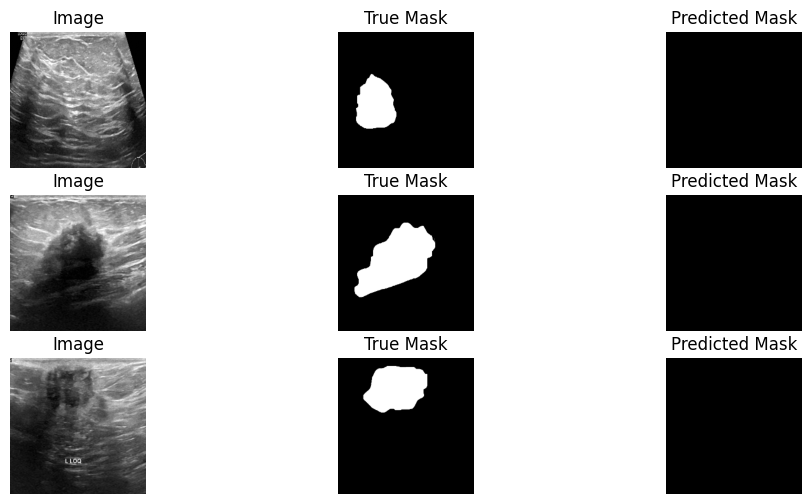

In [ ]:
# Predict on validation set
y_pred = model.predict(X_val) > 0.5  # Threshold at 0.5

# Plot results
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 3, i*3+1)
    plt.imshow(X_val[i])
    plt.title("Image")
    plt.axis('off')

    plt.subplot(3, 3, i*3+2)
    plt.imshow(y_val[i].squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(3, 3, i*3+3)
    plt.imshow(y_pred[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
plt.show()

In [ ]:
# Save model
model.save("breast_segmentation_model.h5")

# Save sample predictions
for i in range(3):
    cv2.imwrite(f"pred_{i}.png", (y_pred[i].squeeze() * 255).astype(np.uint8))